## Replicating Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images

This notebook documents an experimental replication of the research presented in the paper titled `Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images,` which investigated breast histopathology image classification using a Bayesian CNN approach. The specific experiment replicated here compares the classification performance of three models:

*   TL-CNN: This model employs a VGG-16 architecture.
*   bayesian-CNN: This is the original Bayesian CNN model presented in the paper.
*   modified bayesian-CNN: This is the authors' proposed improvement to the original Bayesian CNN model.



In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

from keras.callbacks import EarlyStopping

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Preparation

The experiment utilizes a publicly available breast histopathology image dataset from Kaggle, titled `Breast Histopathology Images` by Paul Mooney (2017). 


In [5]:
data_dir =r'D:\S2\Resources\B Histopatology (mini_cs)'
os.listdir(data_dir)

['cancer', 'normal']

## Image preprocessing

The images have a dimension of `3 x 50 x 50 (Depth x Height x Width)` and are converted to the uint8 format. `Pixel-wise` normalization is performed using a method from OpenCV.

The dataset consists of two classes : cancer (1) and normal (0). By using `80% - 20%` data splitted into `train and validation`

In [6]:
def normalize_and_complement(x):
    x = x.astype('float64')
    return (255 - x) / 255.0

In [7]:
train_datagen = ImageDataGenerator(
                preprocessing_function=normalize_and_complement,
                validation_split = 0.3
                )

In [8]:
train_dt_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'training',
)

validation_dt_generator= train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'validation'
)

Found 19423 images belonging to 2 classes.
Found 8323 images belonging to 2 classes.


In [7]:
pretrained = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (50,50,3))

### TL-CNN

The architecture of `TL-CNN` followed `VGG-16` and used the weight of `VGG-16` pre-trained on the `ImageNet` dataset for classification and performed `transfer learning` to classify the histopathological data.



Based on paper, there were some strategies to solve the over-fitting from TL-CNN:
1. The use of L1 Regularization
2. The use of Dropout


In [12]:
for layer in pretrained.layers:
    layer.trainable = False

In [13]:
## TL_CNN (VGG-16 Architecture)
models = tf.keras.models.Sequential ([

    pretrained,
      
    # Fully Connected Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')

])

In [14]:
models.compile(loss='BinaryCrossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
models.fit(train_dt_generator,
            epochs=100,
            batch_size =64,
            validation_data=validation_dt_generator,
            )

Epoch 1/100
694/694 [==============================] - 17s 24ms/step - loss: 0.4373 - accuracy: 0.8157 - val_loss: 0.3779 - val_accuracy: 0.8275
Epoch 2/100
694/694 [==============================] - 16s 23ms/step - loss: 0.3796 - accuracy: 0.8389 - val_loss: 0.3414 - val_accuracy: 0.8668
Epoch 3/100
694/694 [==============================] - 16s 23ms/step - loss: 0.3554 - accuracy: 0.8499 - val_loss: 0.3213 - val_accuracy: 0.8746
Epoch 4/100
694/694 [==============================] - 16s 23ms/step - loss: 0.3386 - accuracy: 0.8557 - val_loss: 0.3054 - val_accuracy: 0.8843
Epoch 5/100
694/694 [==============================] - 16s 23ms/step - loss: 0.3259 - accuracy: 0.8600 - val_loss: 0.3016 - val_accuracy: 0.8802
Epoch 6/100
694/694 [==============================] - 16s 24ms/step - loss: 0.3101 - accuracy: 0.8660 - val_loss: 0.2906 - val_accuracy: 0.8937
Epoch 7/100
694/694 [==============================] - 16s 23ms/step - loss: 0.2993 - accuracy: 0.8716 - val_loss: 0.2930 - val_ac

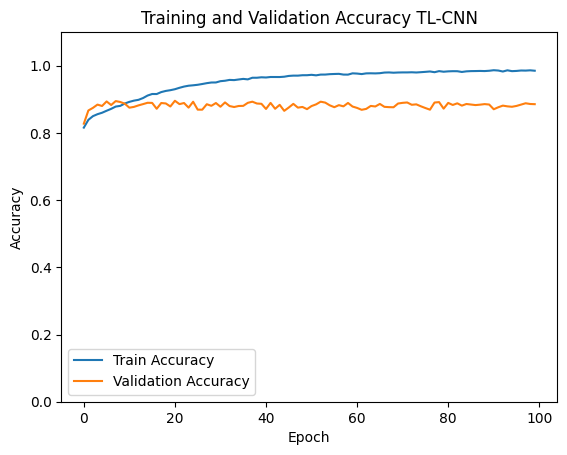

In [16]:
plt.plot(models.history.history['accuracy'], label='Train Accuracy')
plt.plot(models.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy TL-CNN')
plt.legend()
plt.ylim(0.0, 1.1)
plt.savefig('Acc Graph TLCNN 4.jpg', dpi = 600)
plt.show()


### Bayesian-CNN  

All convolution layers are fixed as `(3 x 3)` with `stride = 1` and max pool layers are `(2 x 2)` with `stride = 2`

In [9]:
bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(16, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
    tf.keras.layers.Dropout(0.3),

    #block 3
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(256, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),   
    tf.keras.layers.Dropout(0.5),

    #Fully Connected
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(512, activation = 'relu', activity_regularizer=tf.keras.regularizers.l1(0.001)), #FC1
    tf.keras.layers.Dropout(0.7),
    tfp.layers.DenseFlipout(2, activation ='sigmoid') # Output
        ])

D:\Software\anaconda3\envs\pygpu\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
D:\Software\anaconda3\envs\pygpu\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [10]:
bayesian_cnn.compile(loss='BinaryCrossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
bayesian_cnn.fit(train_dt_generator,
            epochs=100,
            batch_size =128,
            validation_data=validation_dt_generator
            )

Epoch 1/100
607/607 [==============================] - 29s 31ms/step - loss: 1174653.3750 - accuracy: 0.7133 - val_loss: 1022156.0000 - val_accuracy: 0.7162
Epoch 2/100
607/607 [==============================] - 9s 15ms/step - loss: 875565.0000 - accuracy: 0.7161 - val_loss: 732000.3750 - val_accuracy: 0.7162
Epoch 3/100
607/607 [==============================] - 9s 15ms/step - loss: 598401.8750 - accuracy: 0.7161 - val_loss: 470623.9062 - val_accuracy: 0.7162
Epoch 4/100
607/607 [==============================] - 10s 16ms/step - loss: 359250.1875 - accuracy: 0.7161 - val_loss: 257308.2812 - val_accuracy: 0.7162
Epoch 5/100
607/607 [==============================] - 10s 16ms/step - loss: 178064.0000 - accuracy: 0.7161 - val_loss: 110636.1172 - val_accuracy: 0.7162
Epoch 6/100
607/607 [==============================] - 10s 16ms/step - loss: 66879.5781 - accuracy: 0.7160 - val_loss: 33544.7773 - val_accuracy: 0.7162
Epoch 7/100
607/607 [==============================] - 10s 16ms/step - l

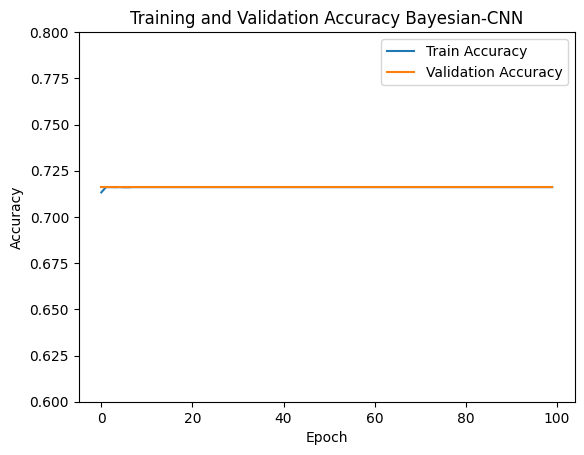

In [12]:
plt.plot(bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Bayesian-CNN')
plt.legend()
plt.ylim(0.6, 0.8)
plt.savefig('Acc Graph Bayesian-CNN 5.jpg', dpi = 600)
plt.show()

### Modified Bayesian-CNN  

In Fully Connected Layer 1, instead of using ReLU, it uses a stochastic-adaptive ReLU

In [14]:
alpha = tf.Variable(initial_value=0.1, trainable = True)

def stochastic_adaptive_relu(x, alpha):
    f_k = x
    return alpha * f_k * tf.cast(f_k > 0, dtype=tf.float32)

In [15]:
class CustomDense(tfp.layers.DenseReparameterization):
    def __init__ (self, units, **kwargs):
        super(CustomDense, self).__init__(units, **kwargs)

    def call(self, inputs):
        output = super(CustomDense, self).call(inputs)
        return stochastic_adaptive_relu(output, alpha)

In [16]:
modified_bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(32, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

    #block 3
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #Fully Connected
    tf.keras.layers.Flatten(),
    CustomDense(256, activity_regularizer=tf.keras.regularizers.l1(0.001)), #FC1 with Stochastic-Adaptive Learning ReLU Activation Function
    tfp.layers.DenseReparameterization (2, activation ='sigmoid') # Output
        ])

D:\Software\anaconda3\envs\pygpu\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
D:\Software\anaconda3\envs\pygpu\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [17]:
modified_bayesian_cnn.compile(loss='BinaryCrossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
modified_bayesian_cnn.fit(train_dt_generator,
            epochs=100,
            batch_size =128,
            validation_data=validation_dt_generator,
            )

Epoch 1/100
607/607 [==============================] - 13s 17ms/step - loss: 295929.5938 - accuracy: 0.7161 - val_loss: 257512.1875 - val_accuracy: 0.7162
Epoch 2/100
607/607 [==============================] - 10s 16ms/step - loss: 220585.6094 - accuracy: 0.7161 - val_loss: 184416.0156 - val_accuracy: 0.7162
Epoch 3/100
607/607 [==============================] - 10s 16ms/step - loss: 150757.0781 - accuracy: 0.7161 - val_loss: 118567.6328 - val_accuracy: 0.7162
Epoch 4/100
607/607 [==============================] - 9s 16ms/step - loss: 90507.8594 - accuracy: 0.7161 - val_loss: 64826.8867 - val_accuracy: 0.7162
Epoch 5/100
607/607 [==============================] - 9s 16ms/step - loss: 44862.4414 - accuracy: 0.7149 - val_loss: 27874.6758 - val_accuracy: 0.7162
Epoch 6/100
607/607 [==============================] - 9s 15ms/step - loss: 16851.1758 - accuracy: 0.7161 - val_loss: 8452.1162 - val_accuracy: 0.7162
Epoch 7/100
607/607 [==============================] - 9s 15ms/step - loss: 4276

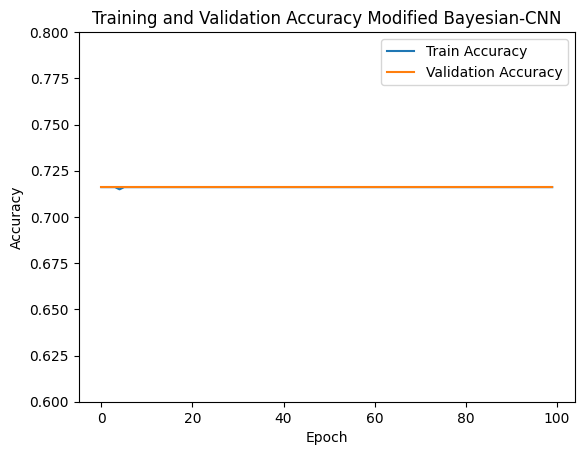

In [19]:
plt.plot(modified_bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(modified_bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Modified Bayesian-CNN')
plt.legend()
plt.ylim(0.6, 0.8)
plt.savefig('Acc Graph Modified Bayesian-CNN 4.jpg', dpi = 600)
plt.show()